# PyCUDA与图像处理-图像相加

In [1]:
import pycuda.autoinit
import pycuda.driver as drv
import numpy as np
from pycuda.compiler import SourceModule
import string
import cv2
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import  animation

In [2]:
def load_kernel_from_file(fname,kname):
    sources = None
    kernel = None
    with open(fname,encoding='utf-8') as f:
        sources = f.read() # 通过str函数转换为unicode编码
        sm = SourceModule(str(sources))
        kernel = sm.get_function(kname)
    return kernel

def load_kernel_from_string(sources,kname):
    sm = SourceModule(str(sources))
    kernel = sm.get_function(kname)
    return kernel

In [3]:
image_add_gray_1 = load_kernel_from_file('../../datas/cuda/08-image-add.cu','image_add_gray_1')
image_add_gray_2 = load_kernel_from_file('../../datas/cuda/08-image-add.cu','image_add_gray_2')
image_add_gray_weighted = load_kernel_from_file('../../datas/cuda/08-image-add.cu','image_add_gray_weighted')
image_add_rgb = load_kernel_from_file('../../datas/cuda/08-image-add.cu','image_add_rgb')
image_add_rgb_weighted = load_kernel_from_file('../../datas/cuda/08-image-add.cu','image_add_rgb_weighted')

In [4]:
src1 = cv2.imread('../../datas/f1.jpg',0)
src2 = cv2.imread('../../datas/f2.jpg',0)
rgb1 = cv2.cvtColor(cv2.imread('../../datas/f1.jpg'),cv2.COLOR_BGR2RGB)
rgb2 = cv2.cvtColor(cv2.imread('../../datas/f2.jpg'),cv2.COLOR_BGR2RGB)

## 图像数据一维索引第一种方法

In [5]:
dst_add_1 = np.zeros_like(src1).astype(np.int32)
dst_add_2 = np.zeros_like(dst_add_1)

In [6]:
rows,cols = src1.shape
length = rows * cols
block_add_1 = (32,32,1)
grid_add_1 = (1 + int(length / (block_add_1[0] * block_add_1[1] + 1)),1, 1)

In [7]:
image_add_gray_1(drv.In(src1.astype(np.int32)),
                 drv.In(src2.astype(np.int32)),
                 drv.Out(dst_add_1),
                 np.int32(length),
                 grid=grid_add_1,block=block_add_1)

In [8]:
dst_add_1[dst_add_1 > 255] = 255
dst_add_1 = dst_add_1.astype(np.uint8)

Text(0.5,1,'SRC2')

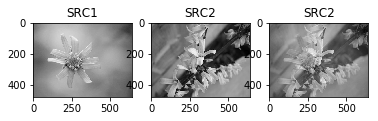

In [9]:
plt.subplot(131)
plt.imshow(src1,'gray')
plt.title('SRC1')
plt.subplot(132)
plt.imshow(src2,'gray')
plt.title('SRC2')
plt.subplot(133)
plt.imshow(dst_add_1,'gray')
plt.title('SRC2')

## 图像数据一维索引第二种方法

In [10]:
block_add_2 = (32,32,1)
grid_add_2 = (int(cols / block_add_2[0]),int(rows / block_add_2[1]), 1)

In [11]:
image_add_gray_2(drv.In(src1.astype(np.int32)),
                 drv.In(src2.astype(np.int32)),
                 drv.Out(dst_add_2),
                 np.int32(cols),np.int32(rows),
                 grid=grid_add_2,block=block_add_2)

Text(0.5,1,'SRC1+SRC1')

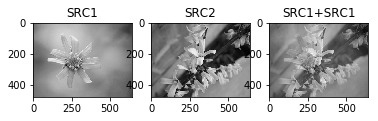

In [12]:
plt.subplot(131)
plt.imshow(src1,'gray')
plt.title('SRC1')
plt.subplot(132)
plt.imshow(src2,'gray')
plt.title('SRC2')
plt.subplot(133)
plt.imshow(dst_add_2,'gray')
plt.title('SRC1+SRC1')

# 灰度图像带权重相加

In [13]:
dst_add_weighted = np.zeros(src1.shape,dtype=np.float32)
alpha = 0.65
beta = 1.0 - alpha

In [14]:
image_add_gray_weighted(drv.In(src1.astype(np.float32)),
                       drv.In(src2.astype(np.float32)),
                       drv.Out(dst_add_weighted),
                        np.float32(alpha),np.float32(beta),
                        np.int32(cols),np.int32(rows),
                       grid=grid_add_2,block=block_add_2)

In [15]:
dst_add_weighted[dst_add_weighted < 0] = 0
dst_add_weighted[dst_add_weighted > 255] = 255
dst_add_weighted = dst_add_weighted.astype(np.uint8)

Text(0.5,1,'0.55 * SRC1 + 0.45 * SRC2')

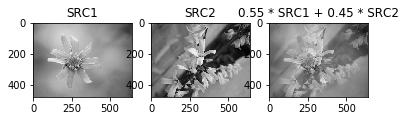

In [16]:
plt.subplot(131)
plt.imshow(src1,'gray')
plt.title('SRC1')
plt.subplot(132)
plt.imshow(src2,'gray')
plt.title('SRC2')
plt.subplot(133)
plt.imshow(dst_add_weighted,'gray')
plt.title('0.55 * SRC1 + 0.45 * SRC2')

In [17]:
dst_rgb = np.zeros_like(rgb1).astype(np.int32)

In [18]:
image_add_rgb(drv.In(rgb1.astype(np.int32)),
              drv.In(rgb2.astype(np.int32)),
              drv.Out(dst_rgb),
              np.int32(cols),np.int32(rows),grid=grid_add_2,block=block_add_2)

In [19]:
dst_rgb[dst_rgb < 0] = 0
dst_rgb[dst_rgb > 255] = 255
dst_rgb = dst_rgb.astype(np.uint8)

Text(0.5,1,'SRC1 + SRC2')

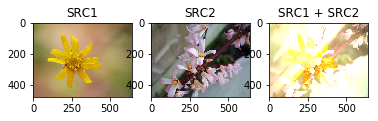

In [20]:
plt.subplot(131)
plt.imshow(rgb1)
plt.title('SRC1')
plt.subplot(132)
plt.imshow(rgb2)
plt.title('SRC2')
plt.subplot(133)
plt.imshow(dst_rgb)
plt.title('SRC1 + SRC2')

In [21]:
dst_rgb_weighted = np.zeros_like(rgb1).astype(np.float32)
alpha = 0.65
beta = 1.0 - alpha

In [22]:
image_add_rgb_weighted(drv.In(rgb1.astype(np.float32)),
              drv.In(rgb2.astype(np.float32)),
              drv.Out(dst_rgb_weighted),
              np.float32(alpha),np.float32(beta),
              np.int32(cols),np.int32(rows),
              grid=grid_add_2,block=block_add_2)

In [23]:
dst_rgb_weighted[dst_rgb_weighted < 0] = 0
dst_rgb_weighted[dst_rgb_weighted > 255] = 255
dst_rgb_weighted = dst_rgb_weighted.astype(np.uint8)

Text(0.5,1,'0.65 * SRC1 + 0.35 * SRC2')

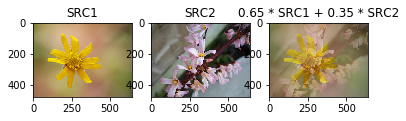

In [24]:
plt.subplot(131)
plt.imshow(rgb1)
plt.title('SRC1')
plt.subplot(132)
plt.imshow(rgb2)
plt.title('SRC2')
plt.subplot(133)
plt.imshow(dst_rgb_weighted)
plt.title('0.65 * SRC1 + 0.35 * SRC2')